# Iteration Workflow


## To create an updated structure after making new commits:

* Generate an updated edge list.
* Copy the previous position file to use as a starting point for the next visualization.
* Open Cytoscape or destroy existing collections if Cytoscape is already running.
* Run all cells to load the visualization.
* [Save the new layout if you make changes](http://localhost:8888/notebooks/lein-topology.ipynb#Save-the-updated-layout-coordinates-if-you-make-changes).

## Import common modules

In [63]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil
import py2cytoscape.util.cytoscapejs as cyjs
import py2cytoscape.cytoscapejs as renderer

from subprocess import call
from IPython.display import Image

import igraph as igraph
import pandas as pd
import numpy as np

import sand.io as io
import sand.graph as sg
import sand.cytoscape.positions as scp
import sand.cytoscape.themes as themes
import sand.cytoscape.version as version

## Load the dataset as a weighted edge list

In [64]:
# Change this path to the directory containing your dataset: This example will use the output of a lein-topology run:
%cd "~/dev/lein-topology"

/Users/bnorton/dev/lein-topology


In [65]:
network_collection = "lein-topology"
network_name = "57af741"

data_path = "./data/" + network_collection + "-" + network_name

In [66]:
edge_file = data_path + ".csv"
edgelist = io.csv_to_edgelist(edge_file)
g = sg.edgelist_to_igraph(edgelist)
g.summary()

'IGRAPH D-W- 107 206 -- \n+ attr: label (v), weight (e)'

## Create communities based on namespaces.

### Build a set of all namespaces. These are the modules of the system. 

They will serve as groups / communities in the visualization.

In [67]:
# Convert fully-qualified names to namespaces:
def fqn_to_ns(fqn):
    return fqn.split('/')[0]


fqn_to_ns('clojure.core/map')

'clojure.core'

In [68]:
namespaces = map(lambda l: fqn_to_ns(l), g.vs['label'])

In [69]:
namespaces[0:5]

['topology.dependencies',
 'clojure.core',
 'topology.edgelist-test',
 'clojure.core',
 'topology.dependencies-test']

### Assign each vertex to a group.

In [70]:
g.vs['group'] = namespaces

## Extract the subgraph of local namespaces 

There are some analyses where it will be useful to see all the vertices. For the high-level architecture diagram, we can focus on the functions local to the library's namespaces. We'll also keep functions used for output.

In [71]:
# List all patterns of vertex names that we want to keep:
names_to_keep = ['topology', 'clojure.core/*err*', 'clojure.core/println']

In [72]:
lv = g.vs(lambda v: any(match in v['label'] for match in names_to_keep))
lg = g.subgraph(lv)

In [73]:
lg.summary()

'IGRAPH D-W- 26 26 -- \n+ attr: group (v), label (v), weight (e)'

## Verify that Cytoscape is running and get the current version

In [74]:
version.print_version()

{
  "cytoscapeVersion": "3.4.0", 
  "apiVersion": "v1"
}


## Load into Cytoscape with a default layout

In [75]:
# Create py2cytoscape client
cy = CyRestClient()

In [76]:
# Optional: delete all existing networks
cy.session.delete()

In [77]:
# Load the network
network = cy.network.create_from_igraph(lg, name=network_name, collection=network_collection)

## Customize the style

Use one of the included themes, or build your own.

In [78]:
style = cy.style.create('Ops')
style.update_defaults(themes.ops.settings)

# Map the label property in the igraph data to Cytoscape's NODE_LABEL visual property
style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

### Give each group a unique color.

In [79]:
border_colors = {
  'topology.finder': themes.colors.BRIGHT_YELLOW,
  'topology.dependencies': themes.colors.BRIGHT_ORANGE,
  'topology.dependencies-test': themes.colors.BRIGHT_ORANGE,
  'topology.qualifier': themes.colors.BRIGHT_PURPLE,
  'topology.symbols': themes.colors.BRIGHT_BLUE,
  'clojure.core': themes.colors.BRIGHT_RED,
  'topology.printer': themes.colors.BRIGHT_RED,
  'leiningen.topology': themes.colors.BRIGHT_WHITE,
}

fill_colors = {
  'topology.finder': themes.colors.DARK_YELLOW,
  'topology.dependencies': themes.colors.DARK_ORANGE,
  'topology.dependencies-test': themes.colors.DARK_ORANGE,
  'topology.qualifier': themes.colors.DARK_PURPLE,
  'topology.symbols': themes.colors.DARK_BLUE,
  'clojure.core': themes.colors.DARK_RED,
  'topology.printer': themes.colors.DARK_RED,
  'leiningen.topology': themes.colors.DARK_WHITE,
}

style.create_discrete_mapping(column='group', col_type='String', vp='NODE_FILL_COLOR', mappings=fill_colors)
style.create_discrete_mapping(column='group', col_type='String', vp='NODE_BORDER_PAINT', mappings=border_colors)

In [80]:
cy.style.apply(style, network)

## Layout

In [81]:
# Apply default layout
cy.layout.apply(name='force-directed', network=network)

In [82]:
# Load layout coordinates from a previous session
positions_file = data_path + "-positions.csv"
scp.layout_from_positions_csv(network, positions_file, cy)

## Save the updated layout coordinates if you make changes

One benefit of this workflow is the ability to manually tweak the algorithmic network layout in Cytoscape.

After making changes, save the coordinates for a later session:

In [21]:
scp.positions_to_csv(network=network, path=positions_file)

## Generate an SVG export

Position the network in Cytoscape the way you want it, then trigger this export:

In [114]:
# Fit to the window:
cy.layout.fit(network=network)

In [113]:
views = network.get_first_view()

In [115]:
# Zoom out slightly:
view.update_network_view('NETWORK_SCALE_FACTOR', 0.75)

In [116]:
# Shift the network to the left:
view.update_network_view('NETWORK_CENTER_X_LOCATION', 550.0)

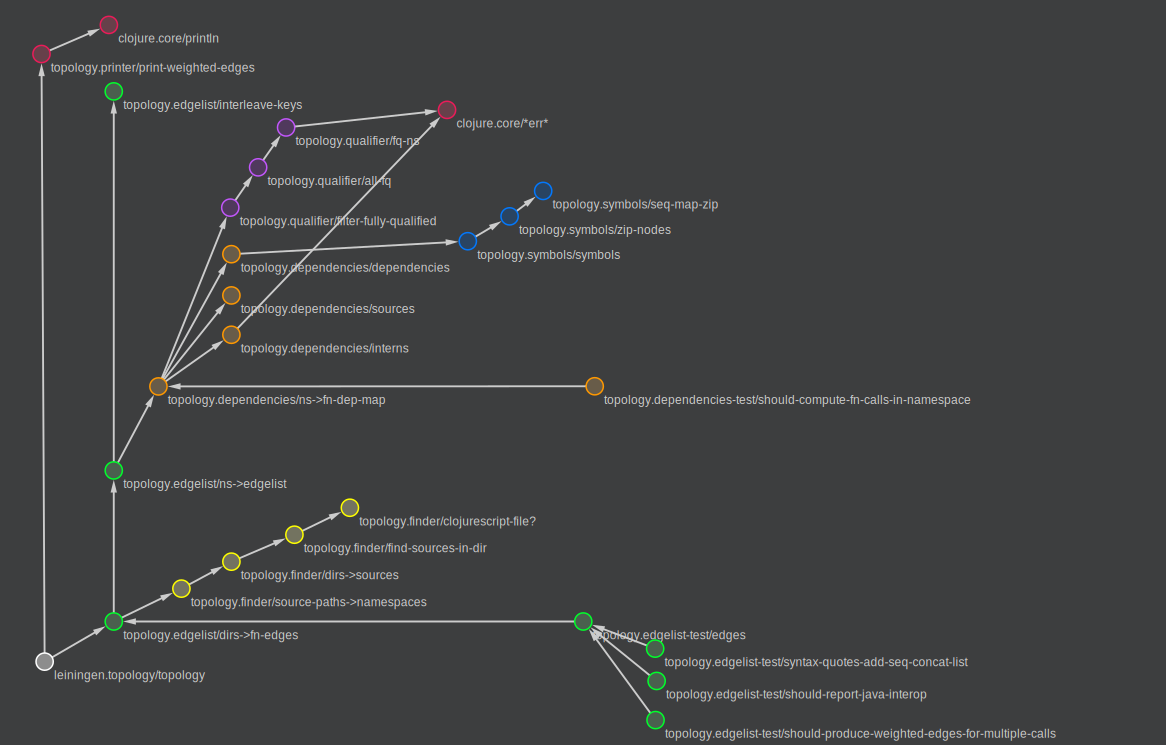

In [124]:
from IPython.display import SVG, display

svg_data = network.get_svg()
display(SVG(svg_data))

In [127]:
# Write the svg to a file if everything looks good:
with open(data_path + '.svg', 'w') as f:
    f.write(svg_data)